GPU available: False, used: False


train data: 272 hour
test data: 15 hour


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 317 K  | train
6 | fc              | Sequential       | 780    | train
-------------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.272     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE: 3.24
MAE: 2.17


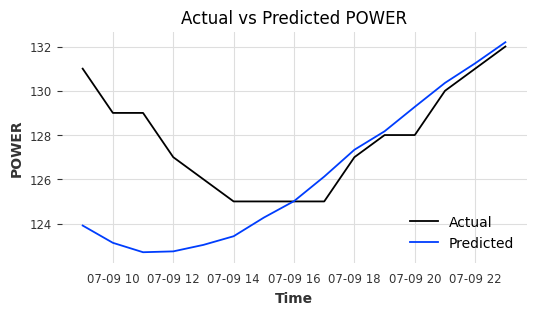

In [3]:
import pandas as pd
from datetime import datetime
from darts import TimeSeries
from darts.models import BlockRNNModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import rmse, mae
import matplotlib.pyplot as plt

# خواندن داده
df = pd.read_csv("../BackUp/updated_file.csv")
df['DATE'] = pd.to_datetime(df['DATE'], format='mixed', errors='coerce')
df = df.dropna(subset=['DATE'])

# فیلتر بر اساس تاریخ و واحد
target_date = pd.to_datetime('6/28/2025 1:00:00 AM')
df_filtered = df[(df['UNIT_NO'] == 7) & (df['DATE'] >= target_date)]

# حذف تاریخ‌های تکراری
df_filtered = df_filtered.drop_duplicates(subset='DATE')

# ساخت سری هدف
series = TimeSeries.from_dataframe(
    df_filtered,
    time_col='DATE',
    value_cols='POWER',
    freq='h'
)

# ساخت سری covariates شامل DAMA و ROTOOBAT
covariates = TimeSeries.from_dataframe(
    df_filtered,
    time_col='DATE',
    value_cols=['DAMA', 'ROTOOBAT'],
    freq='h'
)

# نرمال‌سازی سری‌ها
scaler_series = Scaler(MinMaxScaler(feature_range=(0, 1)))
series_scaled = scaler_series.fit_transform(series)

scaler_cov = Scaler(MinMaxScaler(feature_range=(0, 1)))
covariates_scaled = scaler_cov.fit_transform(covariates)

# تقسیم داده‌ها به آموزش و تست
train_ratio = 0.95
train_series, test_series = series_scaled.split_after(train_ratio)
train_cov, test_cov = covariates_scaled.split_after(train_ratio)

print(f"train data: {len(train_series)} hour")
print(f"test data: {len(test_series)} hour")

# ساخت مدل LSTM با BlockRNNModel
model = BlockRNNModel(
    model='LSTM',
    input_chunk_length=24,
    output_chunk_length=12,
    hidden_dim=64,
    n_rnn_layers=10,
    dropout=0.2,
    n_epochs=100,
    random_state=42
)

# آموزش مدل با covariates چند‌متغیره
model.fit(
    series=train_series,
    past_covariates=train_cov,
    verbose=True
)

# پیش‌بینی
pred = model.predict(n=len(test_series), series=train_series, past_covariates=covariates_scaled)

# بازگرداندن مقیاس اصلی
pred = scaler_series.inverse_transform(pred)
test_series = scaler_series.inverse_transform(test_series)

# ارزیابی
print(f"RMSE: {rmse(test_series, pred):.2f}")
print(f"MAE: {mae(test_series, pred):.2f}")

# رسم نمودار
df_test = test_series.pd_dataframe()
df_pred = pred.pd_dataframe()

plt.figure(figsize=(6, 3))
plt.plot(df_test.index, df_test['POWER'], label='Actual')
plt.plot(df_pred.index, df_pred['POWER'], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted POWER")
plt.xlabel("Time")
plt.ylabel("POWER")
plt.grid(True)
plt.show()
